In [1]:
import numpy as np
np.set_printoptions(precision=3)

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#plt.style.use('ggplot')

from qr import (power_iteration, power_iteration_matrix, simultaneous_orthogonalization,
                plot_vector ,plot_basis)

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Working Example

In [2]:
Q = np.array([
    [ 0.00,  -0.80, -0.60],
    [ 0.80,  -0.36,  0.48],
    [ 0.60,   0.48, -0.64]
])

D = np.array([
    [9, 0, 0],
    [0, 4, 0],
    [0, 0, 1]
])

A = Q.T @ D @ Q

In [3]:
A

array([[ 2.92 , -0.864,  1.152],
       [-0.864,  6.509,  3.322],
       [ 1.152,  3.322,  4.571]])

In [4]:
e_vals, e_vectors = np.linalg.eig(A)

In [5]:
print(e_vals)
print(e_vectors)

[ 4.  1.  9.]
[[  8.000e-01  -6.000e-01  -3.872e-17]
 [ -3.600e-01  -4.800e-01   8.000e-01]
 [  4.800e-01   6.400e-01   6.000e-01]]


## Power Iteration

In [6]:
e, memo = power_iteration(A)

In [7]:
e

array([  4.185e-06,  -8.000e-01,  -6.000e-01])

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


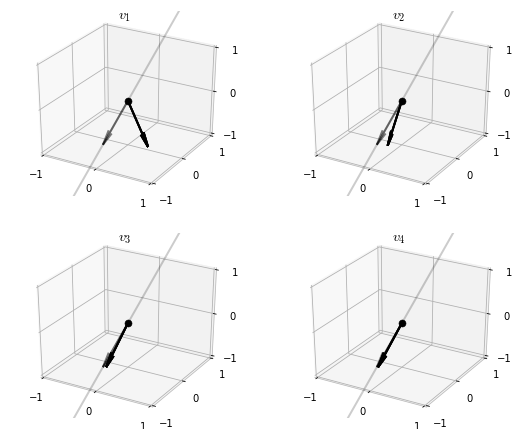

In [8]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))

for i, v in enumerate(memo[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', axisbg='white')
    plot_vector(ax, v, e)
    ax.set_title("$v_{{{}}}$".format(i+1))

## Convergence with an Orthogonal Vector

In [9]:
e, memo = power_iteration(A, v=[1, 0, 0])

/Users/matthewdrury/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


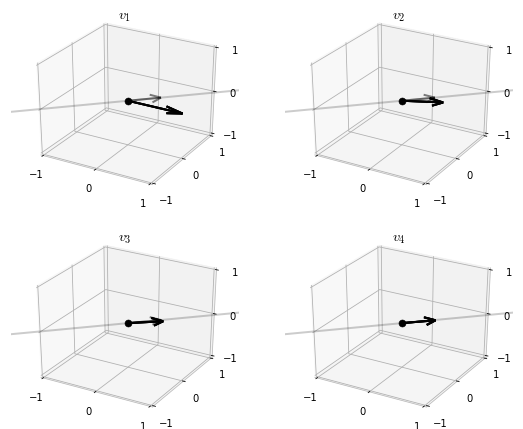

In [10]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))

for i, v in enumerate(memo[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', axisbg='white')
    plot_vector(ax, v, e)
    ax.set_title("$v_{{{}}}$".format(i+1))

## Power Iteration Applied to Matrix

In [18]:
X, basies = power_iteration_matrix(A)

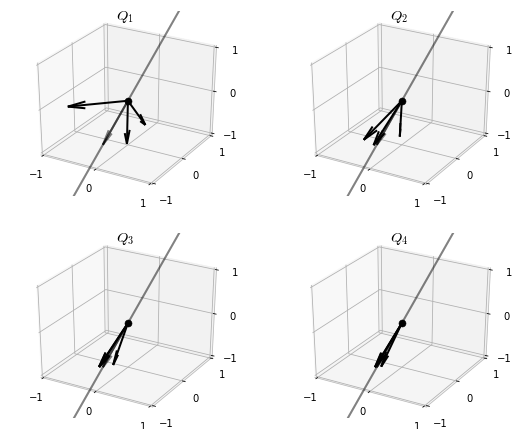

In [20]:
fig = plt.figure(figsize=(12*0.75, 10*0.75))

for i, Q in enumerate(basies[:4]):
    ax = fig.add_subplot(2, 2, i+1, projection='3d', facecolor='white')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$Q_{{{}}}$".format(i+1))

## Simultaneous Orthogonalization

In [21]:
Q, basies = simultaneous_orthogonalization(A)
Q

array([[ -6.189e-04,  -8.000e-01,  -6.000e-01],
       [  8.003e-01,   3.594e-01,  -4.800e-01],
       [  5.996e-01,  -4.805e-01,   6.400e-01]])

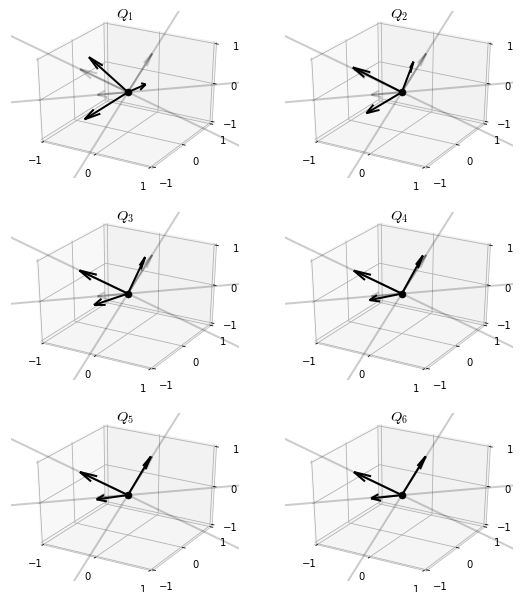

In [22]:
fig = plt.figure(figsize=(12*0.75, 14*0.75))

for i, Q in enumerate(basies[:6]):
    ax = fig.add_subplot(3, 2, i+1, projection='3d', facecolor='white')
    plot_basis(ax, Q, basies[-1])
    ax.set_title("$Q_{{{}}}$".format(i+1))